## Model selection with Pipeline
### Topic (**Inflation**) according to each news portal

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Load

In [2]:
import pickle

In [3]:
import pandas as pd
import numpy as np

In [4]:
izq = pickle.load(open('data/df_clean_izq.pkl','rb'))
der = pickle.load(open('data/df_clean_der.pkl','rb'))

### Preparte Dataframe

In [98]:
izq_inf = izq[izq.topics == 'inflation']
der_inf = der[der.topics == 'inflation']

In [99]:
izq_inf['bias'] = 'left'
der_inf['bias'] = 'right'

In [100]:
df_inf = izq_inf.loc[:,['bias', 'body']].append(der_inf.loc[:,['bias', 'body']])

### Split Train - Test

In [5]:
from sklearn.model_selection import train_test_split

In [102]:
X = df_inf.body

In [103]:
y = df_inf.bias

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y)

In [105]:
print(f"Train shape: {X_train.shape[0] / X.shape[0]}\nTest shape: {X_test.shape[0] / X.shape[0]}")

Train shape: 0.7435897435897436
Test shape: 0.2564102564102564


In [106]:
print(f"Target balance\nTrain:\n{y_train.value_counts(normalize=True)}\nTest:\n{y_test.value_counts(normalize=True)}")

Target balance
Train:
right    0.534483
left     0.465517
Name: bias, dtype: float64
Test:
right    0.55
left     0.45
Name: bias, dtype: float64


### Looking for the model

#### Preparing the input

In [6]:
import re
import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [7]:
stopwords_sp = stopwords.words('spanish')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [9]:
def removal(text):
    text = re.sub(r'(\d|\$|\%|\+)', '', text.lower())
    return re.sub(r'\d+', '', text)

#### Folds config

In [10]:
from sklearn.model_selection import StratifiedKFold


In [32]:
folds = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)

#### Calling the models

In [11]:
from sklearn.naive_bayes import MultinomialNB

In [12]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [15]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

### Pipeline

#### Vectorizers + Model switcher ad-hoc class + Models 

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

In [17]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = None):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [18]:
pipeline = Pipeline([
    ('cv', CountVectorizer(stop_words=stopwords_sp)),
    ('tfidf', TfidfTransformer()),
    ('clf', ClfSwitcher()),
])

parameters = [
    {
        # vectorizer params
        'cv__max_df': (0.5, 0.75, 1.0),
        'cv__lowercase':  [True],
        'cv__strip_accents':['unicode'], 
        'cv__preprocessor':[removal],
        'cv__ngram_range': [(1,1),(1,2),(2,2)],
        'cv__min_df':[1,2,3],
        # model params
        'clf__estimator': [SGDClassifier()], # SVM if hinge loss / logreg if log loss
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4],
        'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    },
    {
        # vectorizer params
        'cv__max_df': (0.5, 0.75, 1.0),
        'cv__lowercase':  [True],
        'cv__strip_accents':['unicode'], 
        'cv__preprocessor':[removal],
        'cv__ngram_range': [(1,1),(1,2),(2,2)],
        'cv__min_df':[1,2,3],
        # model params
        'clf__estimator': [MultinomialNB()],
        'clf__estimator__alpha': (1e-2, 1e-3, 1e-1),
    },
    {
        # vectorizer params
        'cv__max_df': (0.5, 0.75, 1.0),
        'cv__lowercase':  [True],
        'cv__strip_accents':['unicode'], 
        'cv__preprocessor':[removal],
        'cv__ngram_range': [(1,1),(1,2),(2,2)],
        'cv__min_df':[1,2,3],
        # model params
        'clf__estimator': [KNeighborsClassifier()],
        'clf__estimator__n_neighbors': range(1,4),
        'clf__estimator__weights' : ['uniform', 'distance'],
        'clf__estimator__p' : [1, 2, 3]
    },
    {
        # vectorizer params
        'cv__max_df': (0.5, 0.75, 1.0),
        'cv__lowercase':  [True],
        'cv__strip_accents':['unicode'], 
        'cv__preprocessor':[removal],
        'cv__ngram_range': [(1,1),(1,2),(2,2)],
        'cv__min_df':[1,2,3],
        # model params
        'clf__estimator': [LogisticRegression()],
        'clf__estimator__C': [1, 10, 100, 1000],
        'clf__estimator__penalty': ['l1', 'l2',],
        'clf__estimator__solver': ['saga']
    },
    {
        # vectorizer params
        'cv__max_df': (0.5, 0.75, 1.0),
        'cv__lowercase':  [True],
        'cv__strip_accents':['unicode'], 
        'cv__preprocessor':[removal],
        'cv__ngram_range': [(1,1),(1,2),(2,2)],
        'cv__min_df':[1,2,3],
        # model params
        'clf__estimator': [DecisionTreeClassifier()],
        "clf__estimator__criterion" : ["gini", "entropy"],
        "clf__estimator__min_samples_leaf": [5,10,15,20,2], 
        "clf__estimator__max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17],
        "clf__estimator__min_samples_split": [2, 3, 4,None]
    },    
]

#### Tuning model

In [19]:
from sklearn.model_selection import GridSearchCV

In [29]:
grid = GridSearchCV(pipeline, parameters, cv=folds, n_jobs=12, return_train_score=True, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18549 candidates, totalling 92745 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    5.3s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    9.1s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   14.7s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   22.1s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   30.0s
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed:   39.5s
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed:   50.9s
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 3848 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 4584 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 5384 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 6248 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 7176 tasks      | 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
   

In [108]:
print(f'''Best parameters: {grid.best_params_}
Best Train Score: {grid.best_score_}
Best Test Score: {grid.score(X_test, y_test)}''')

Best parameters: {'clf__estimator': SGDClassifier(max_iter=50, tol=0.0001), 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 50, 'clf__estimator__penalty': 'l2', 'clf__estimator__tol': 0.0001, 'cv__lowercase': True, 'cv__max_df': 0.5, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__preprocessor': <function removal at 0x7f88b3e2e950>, 'cv__strip_accents': 'unicode'}
Best Train Score: 1.0
Best Test Score: 0.95


#### Report

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [111]:
grid.best_estimator_, grid.best_score_, grid.best_params_

(Pipeline(steps=[('cv',
                  CountVectorizer(max_df=0.5, min_df=2,
                                  preprocessor=<function removal at 0x7f88b3e2e950>,
                                  stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                              'a', 'los', 'del', 'se', 'las',
                                              'por', 'un', 'para', 'con', 'no',
                                              'una', 'su', 'al', 'lo', 'como',
                                              'más', 'pero', 'sus', 'le', 'ya',
                                              'o', 'este', 'sí', 'porque', ...],
                                  strip_accents='unicode')),
                 ('tfidf', TfidfTransformer()),
                 ('clf',
                  ClfSwitcher(estimator=SGDClassifier(max_iter=50,
                                                      tol=0.0001)))]),
 1.0,
 {'clf__estimator': SGDClassifier(max_iter=50, tol=0.0001),
  'clf__estimator

In [112]:
grid_pred = grid.predict(X_test)

In [113]:
matrix = confusion_matrix(y_test, grid_pred)
accuracy_score(y_test, grid_pred)

0.95

In [114]:
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

        left       0.90      1.00      0.95         9
       right       1.00      0.91      0.95        11

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



In [132]:
results = pd.DataFrame({'actual': y_test, 'pred': grid_pred, 'acc': y_test == grid_pred})
results

,actual,pred,acc
31,left,left,True
19,left,left,True
6,right,right,True
32,right,right,True
0,right,right,True
1,right,left,False
37,right,right,True
29,right,right,True
27,left,left,True
12,left,left,True


In [135]:
results.actual.value_counts(), results.pred.value_counts()

(right    11
 left      9
 Name: actual, dtype: int64,
 right    10
 left     10
 Name: pred, dtype: int64)

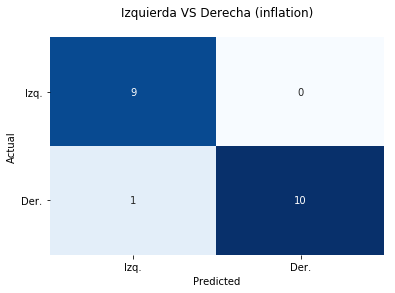

In [130]:
sns.heatmap(confusion_matrix(y_test, grid_pred), annot=True, cbar=False, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5],['Izq.','Der.'])
plt.yticks([0.5, 1.5],['Izq.','Der.'], rotation = 0.5)
plt.title('Izquierda VS Derecha (inflation)\n', loc='center')
plt.show()

### Topic (**Exchange**) according to each news portal

### Prepare Dataframe

In [138]:
izq_ex = izq[izq.topics == 'exchange']
der_ex = der[der.topics == 'exchange']

In [139]:
izq_ex['bias'] = 'left'
der_ex['bias'] = 'right'

In [140]:
df_ex = izq_ex.loc[:,['bias', 'body']].append(der_ex.loc[:,['bias', 'body']])

### Split Train - Test

In [141]:
X = df_ex.body

In [142]:
y = df_ex.bias

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y)

In [144]:
print(f"Train shape: {X_train.shape[0] / X.shape[0]}\nTest shape: {X_test.shape[0] / X.shape[0]}")

Train shape: 0.75
Test shape: 0.25


In [145]:
print(f"Target balance\nTrain:\n{y_train.value_counts(normalize=True)}\nTest:\n{y_test.value_counts(normalize=True)}")

Target balance
Train:
right    0.52381
left     0.47619
Name: bias, dtype: float64
Test:
right    0.571429
left     0.428571
Name: bias, dtype: float64


### Pipeline

#### Tuning model

In [146]:
grid = GridSearchCV(pipeline, parameters, cv=folds, n_jobs=12, return_train_score=True, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18549 candidates, totalling 92745 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    4.5s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    7.3s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   11.5s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   16.6s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   22.7s
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed:   30.2s
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed:   38.5s
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:   47.9s
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:   58.8s
[Parallel(n_jobs=12)]: Done 3848 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 4584 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 5384 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 6248 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 7176 tasks      | 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
   

In [147]:
print(f'''Best parameters: {grid.best_params_}
Best Train Score: {grid.best_score_}
Best Test Score: {grid.score(X_test, y_test)}''')

Best parameters: {'clf__estimator': SGDClassifier(loss='log', max_iter=50, tol=0.0001), 'clf__estimator__loss': 'log', 'clf__estimator__max_iter': 50, 'clf__estimator__penalty': 'l2', 'clf__estimator__tol': 0.0001, 'cv__lowercase': True, 'cv__max_df': 0.75, 'cv__min_df': 1, 'cv__ngram_range': (2, 2), 'cv__preprocessor': <function removal at 0x7f88b3e2e950>, 'cv__strip_accents': 'unicode'}
Best Train Score: 1.0
Best Test Score: 1.0


#### Report

In [148]:
grid.best_estimator_, grid.best_score_, grid.best_params_

(Pipeline(steps=[('cv',
                  CountVectorizer(max_df=0.75, ngram_range=(2, 2),
                                  preprocessor=<function removal at 0x7f88b3e2e950>,
                                  stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                              'a', 'los', 'del', 'se', 'las',
                                              'por', 'un', 'para', 'con', 'no',
                                              'una', 'su', 'al', 'lo', 'como',
                                              'más', 'pero', 'sus', 'le', 'ya',
                                              'o', 'este', 'sí', 'porque', ...],
                                  strip_accents='unicode')),
                 ('tfidf', TfidfTransformer()),
                 ('clf',
                  ClfSwitcher(estimator=SGDClassifier(loss='log', max_iter=50,
                                                      tol=0.0001)))]),
 1.0,
 {'clf__estimator': SGDClassifier(loss='log', max_iter

In [149]:
grid_pred = grid.predict(X_test)

In [150]:
matrix = confusion_matrix(y_test, grid_pred)
accuracy_score(y_test, grid_pred)

1.0

In [151]:
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

        left       1.00      1.00      1.00         6
       right       1.00      1.00      1.00         8

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [152]:
results = pd.DataFrame({'actual': y_test, 'pred': grid_pred, 'acc': y_test == grid_pred})
results

,actual,pred,acc
44,right,right,True
56,left,left,True
47,left,left,True
54,left,left,True
37,left,left,True
48,right,right,True
60,right,right,True
62,right,right,True
55,right,right,True
60,left,left,True


In [153]:
results.actual.value_counts(), results.pred.value_counts()

(right    8
 left     6
 Name: actual, dtype: int64,
 right    8
 left     6
 Name: pred, dtype: int64)

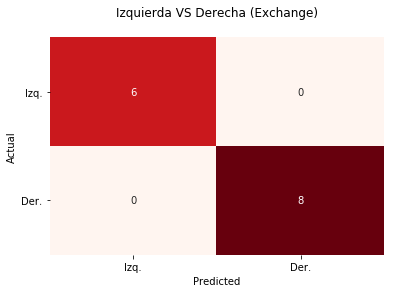

In [154]:
sns.heatmap(confusion_matrix(y_test, grid_pred), annot=True, cbar=False, cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5],['Izq.','Der.'])
plt.yticks([0.5, 1.5],['Izq.','Der.'], rotation = 0.5)
plt.title('Izquierda VS Derecha (Exchange)\n', loc='center')
plt.show()

### All topics according to each news portal

### Prepare Dataframe

In [22]:
izq.drop(['topics'], axis=1, inplace=True)
der.drop(['topics'], axis=1, inplace=True)

In [23]:
izq['bias'] = 'left'
der['bias'] = 'right'

In [24]:
df_all = izq.loc[:,['bias', 'body']].append(der.loc[:,['bias', 'body']])

In [25]:
df_all.shape

(134, 2)

### Split Train - Test

In [26]:
X = df_all.body

In [27]:
y = df_all.bias

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y)

In [29]:
print(f"Train shape: {X_train.shape[0] / X.shape[0]}\nTest shape: {X_test.shape[0] / X.shape[0]}")

Train shape: 0.746268656716418
Test shape: 0.2537313432835821


In [30]:
print(f"Target balance\nTrain:\n{y_train.value_counts(normalize=True)}\nTest:\n{y_test.value_counts(normalize=True)}")

Target balance
Train:
right    0.54
left     0.46
Name: bias, dtype: float64
Test:
right    0.529412
left     0.470588
Name: bias, dtype: float64


### Pipeline

#### Tuning model

In [33]:
grid = GridSearchCV(pipeline, parameters, cv=folds, n_jobs=12, return_train_score=True, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18549 candidates, totalling 92745 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    7.0s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   13.3s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   21.8s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   33.3s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   46.2s
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 3848 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 4584 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 5384 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 6248 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 7176 tasks      | 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
   

In [34]:
print(f'''Best parameters: {grid.best_params_}
Best Train Score: {grid.best_score_}
Best Test Score: {grid.score(X_test, y_test)}''')

Best parameters: {'clf__estimator': SGDClassifier(max_iter=50, penalty='elasticnet', tol=0.0001), 'clf__estimator__loss': 'hinge', 'clf__estimator__max_iter': 50, 'clf__estimator__penalty': 'elasticnet', 'clf__estimator__tol': 0.0001, 'cv__lowercase': True, 'cv__max_df': 0.5, 'cv__min_df': 3, 'cv__ngram_range': (1, 2), 'cv__preprocessor': <function removal at 0x7fc9b1f8cb90>, 'cv__strip_accents': 'unicode'}
Best Train Score: 0.99
Best Test Score: 0.9117647058823529


#### Report

In [35]:
grid.best_estimator_, grid.best_score_, grid.best_params_

(Pipeline(steps=[('cv',
                  CountVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 2),
                                  preprocessor=<function removal at 0x7fc9b1f8cb90>,
                                  stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                              'a', 'los', 'del', 'se', 'las',
                                              'por', 'un', 'para', 'con', 'no',
                                              'una', 'su', 'al', 'lo', 'como',
                                              'más', 'pero', 'sus', 'le', 'ya',
                                              'o', 'este', 'sí', 'porque', ...],
                                  strip_accents='unicode')),
                 ('tfidf', TfidfTransformer()),
                 ('clf',
                  ClfSwitcher(estimator=SGDClassifier(max_iter=50,
                                                      penalty='elasticnet',
                                                      tol=

In [36]:
grid_pred = grid.predict(X_test)

In [37]:
matrix = confusion_matrix(y_test, grid_pred)
accuracy_score(y_test, grid_pred)

0.9117647058823529

In [38]:
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

        left       1.00      0.81      0.90        16
       right       0.86      1.00      0.92        18

    accuracy                           0.91        34
   macro avg       0.93      0.91      0.91        34
weighted avg       0.92      0.91      0.91        34



In [43]:
results = pd.DataFrame({'actual': y_test, 'pred': grid_pred, 'acc': y_test == grid_pred})
results[results.acc == False]

,actual,pred,acc
36,left,right,False
9,left,right,False
6,left,right,False


In [40]:
results.actual.value_counts(), results.pred.value_counts()

(right    18
 left     16
 Name: actual, dtype: int64,
 right    21
 left     13
 Name: pred, dtype: int64)

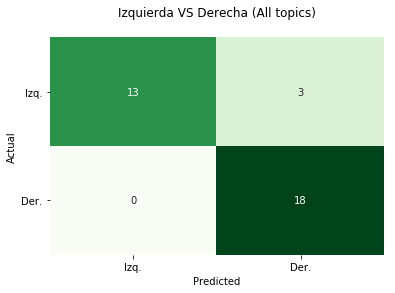

In [44]:
sns.heatmap(confusion_matrix(y_test, grid_pred), annot=True, cbar=False, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5],['Izq.','Der.'])
plt.yticks([0.5, 1.5],['Izq.','Der.'], rotation = 0.5)
plt.title('Izquierda VS Derecha (All topics)\n', loc='center')
plt.show()